In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
import helper as hlp

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('paper')
%matplotlib inline

W1202 15:38:27.794972 4529237440 deprecation.py:323] From /usr/local/anaconda3/envs/ece421/lib/python3.6/site-packages/tensorflow/python/compat/v2_compat.py:61: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


In [23]:
# Loading data
data = np.load('data2D.npy')
#data = np.load('data100D.npy')
[num_pts, dim] = np.shape(data)

## 1. K-means
#### 1.1

In [3]:
# Distance function for K-means
def distanceFunc(X_input, MU_input):
    # Inputs
    # X: is an NxD matrix (N observations and D dimensions)
    # MU: is an KxD matrix (K means and D dimensions)
    # Outputs
    # pair_dist: is the squared pairwise distance matrix (NxK)
    
    # make the matrices similar dimensions
    MU = tf.expand_dims(MU_input, 0)  # 1 x K x D
    X = tf.expand_dims(X_input, 1) # N x 1 x D

    return tf.reduce_sum(tf.square(tf.subtract(X, MU)), axis=2)

def getCluster(X, MU):
    dist = distanceFunc(X, MU)
    return tf.math.argmin(dist, axis=1)

In [4]:
def kmeans_loss(X, MU):
    return tf.reduce_sum(tf.reduce_min(distanceFunc(X,MU), axis=1))

def buildGraph(dim, cluster_centers=3):
    tf.set_random_seed(421)
    
    # initialize the placeholder for the data
    x = tf.placeholder(shape=[None, dim], dtype=tf.float64)
    
    # Sample a random uniform distribution for the cluster centers
    mu = tf.Variable(tf.random.normal(shape=[cluster_centers, dim], mean=0.0, stddev=1.0, dtype=tf.float64))
    
    # set up the loss function
    loss_function = kmeans_loss(x, mu)
    
    # set the adam optimizer to minimize the loss function
    optimizer = tf.train.AdamOptimizer(learning_rate=0.1, beta1=0.9, beta2=0.99, epsilon=1e-5)\
        .minimize(loss_function)
    
    return x, mu, optimizer, loss_function

def do_the_learning(train_data, k=3, epochs=200, use_valid=False, plot=True):
    sess = tf.Session()
    with sess.as_default():
    
        x, mu, optimizer, lf = buildGraph(dim=dim, cluster_centers=k)

        init = tf.global_variables_initializer()
        sess.run(init)

        train_loss = np.zeros(epochs)
        val_loss = np.zeros(epochs)
        for i in range(0, epochs):
            sess.run(optimizer, feed_dict={x: train_data})
            train_loss[i] = sess.run(lf, feed_dict={x: train_data})

            if use_valid:
                val_loss[i] = sess.run(lf, feed_dict={x: val_data})

        clusters = sess.run(mu)
        cluster_assignment = getCluster(sess.run(x, feed_dict={x: train_data}), clusters).eval()
        
        if use_valid:
            val_cluster_assignment = getCluster(sess.run(x, feed_dict={x: val_data}), clusters).eval()
        
    count = np.bincount(cluster_assignment)
    for i in range(0, len(count)):
        print("Cluster " + str(i) +":", str(count[i]/len(cluster_assignment)*100) + "%")
    
    if plot:
        # scatter plot
        plt.scatter(train_data[:, 0], train_data[:, 1], c=cluster_assignment)
        plt.scatter(clusters[:, 0], clusters[:, 1])
        plt.title('Training scatter plot for K=' + str(k))
        plt.ylabel('x_2')
        plt.xlabel('x_1')
        plt.show()
        
        if use_valid:
            plt.scatter(val_data[:, 0], val_data[:, 1], c=val_cluster_assignment)
            plt.scatter(clusters[:, 0], clusters[:, 1])
            plt.title('Validation scatter plot for K=' + str(k))
            plt.ylabel('x_2')
            plt.xlabel('x_1')
            plt.show()
            
        # plot losses
        plt.plot(train_loss, label="Training Set")
        if use_valid:
            plt.plot(val_loss, label="Validation Set")
        plt.title('Losses for Data Sets After Each Epoch with K=' + str(k))
        plt.legend()
        plt.ylabel('Loss')
        plt.xlabel('Epoch Number')
        plt.show()
    
    # display final loss
    print("Final training loss:", train_loss[-1])
    if use_valid:
        print("Final validation loss:", val_loss[-1])
    return train_loss[-1], val_loss[-1]

Cluster 0: 38.129999999999995%
Cluster 1: 23.810000000000002%
Cluster 2: 38.06%


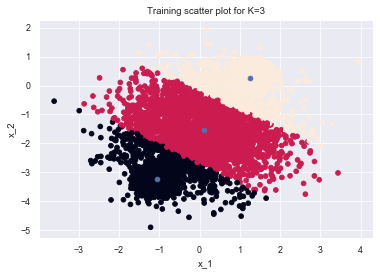

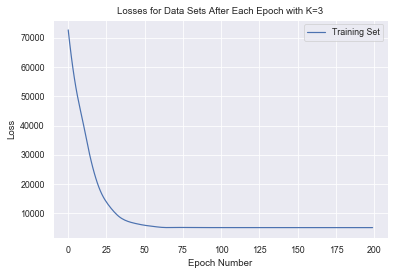

Final training loss: 5110.946540434149


(5110.946540434149, 0.0)

In [5]:
do_the_learning(data, k=3)

#### 1.2

Cluster 0: 100.0%


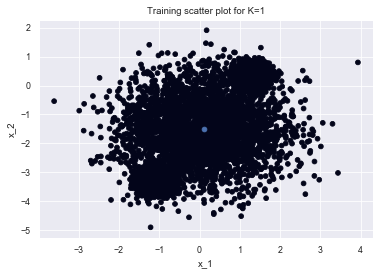

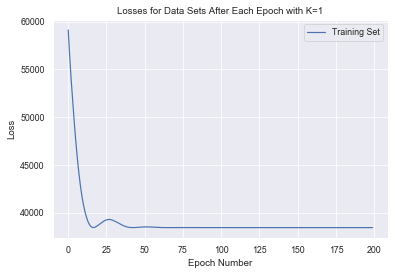

Final training loss: 38453.48879936148
Cluster 0: 49.55%
Cluster 1: 50.449999999999996%


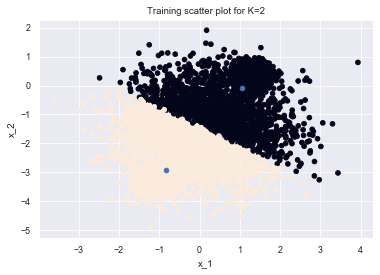

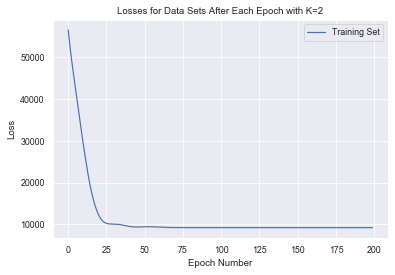

Final training loss: 9203.354114996644
Cluster 0: 23.810000000000002%
Cluster 1: 38.129999999999995%
Cluster 2: 38.06%


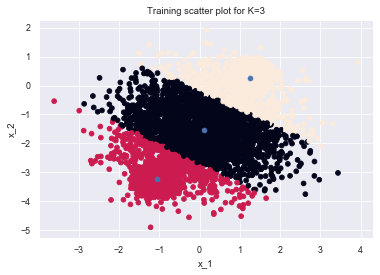

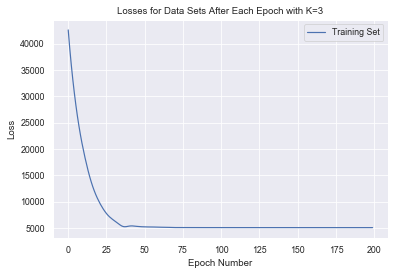

Final training loss: 5110.945410073188
Cluster 0: 37.13%
Cluster 1: 12.04%
Cluster 2: 13.530000000000001%
Cluster 3: 37.3%


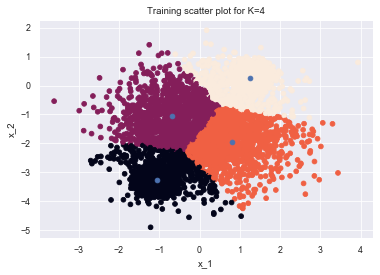

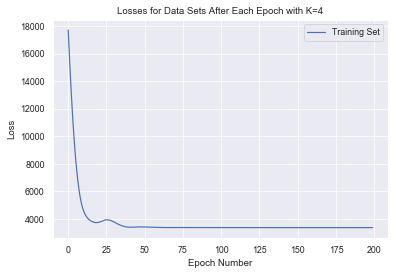

Final training loss: 3374.0382906432237
Cluster 0: 10.77%
Cluster 1: 35.76%
Cluster 2: 8.81%
Cluster 3: 36.24%
Cluster 4: 8.42%


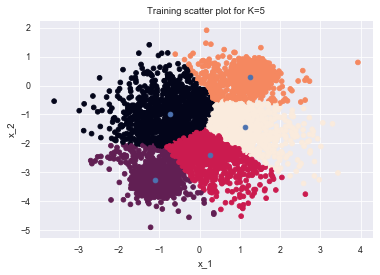

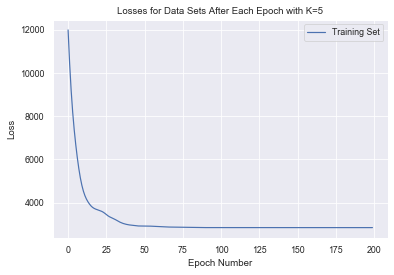

Final training loss: 2847.350259456065


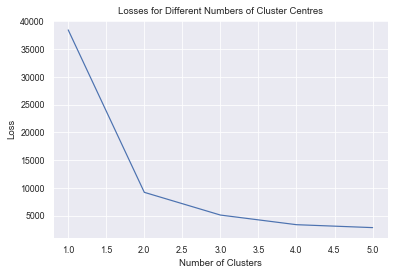

In [6]:
def get_the_right_one(tuple): return tuple[0]

final_losses = []
final_losses.append(get_the_right_one(do_the_learning(data, k=1)))
final_losses.append(get_the_right_one(do_the_learning(data, k=2)))
final_losses.append(get_the_right_one(do_the_learning(data, k=3)))
final_losses.append(get_the_right_one(do_the_learning(data, k=4)))
final_losses.append(get_the_right_one(do_the_learning(data, k=5)))


plt.plot([1,2,3,4,5],final_losses)
plt.title('Losses for Different Numbers of Cluster Centres')
plt.ylabel('Loss')
plt.xlabel('Number of Clusters')
plt.show()

As the number of clusters gets larger, the cluster centres spread out in space and the total loss decreases as
the points that were further away are assigned to new cluster centres that are closer.
The number of clusters we feel is best is 3. As is evident from the above graph, which shows loss with respect
to the number of cluster centres, the amount the loss decreases for every additional cluster centre decreases
substantially after this point. (i.e. the derivative of the loss function with respect to cluster centres
becomes closer to zero) In theory, with k equal to the number of training points loss would be zero, but
at this point the model would be heavily overfitted and requires a large amount of computational resources to train.


#### 1.3

In [24]:
USE_VALIDATION = True
# For Validation set
if USE_VALIDATION:
  valid_batch = int(num_pts / 3.0)
  np.random.seed(45689)
  rnd_idx = np.arange(num_pts)
  np.random.shuffle(rnd_idx)
  val_data = data[rnd_idx[:valid_batch]]
  data2 = data[rnd_idx[valid_batch:]]

Cluster 0: 100.0%


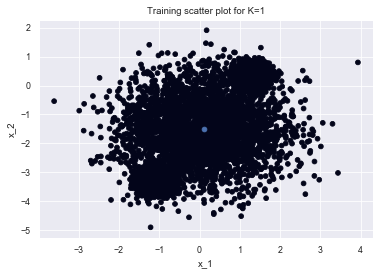

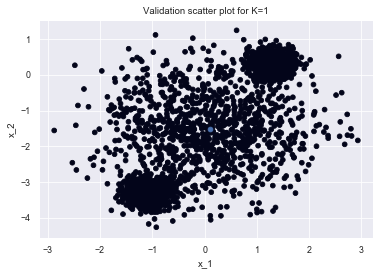

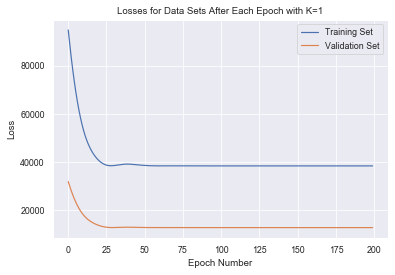

Final training loss: 38453.488852170194
Final validation loss: 12860.76946077383
Cluster 0: 49.55%
Cluster 1: 50.449999999999996%


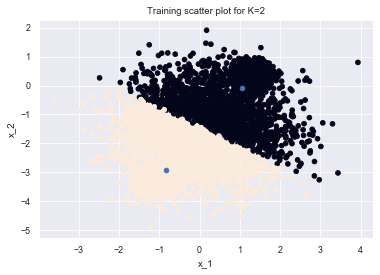

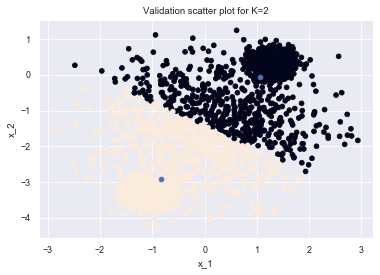

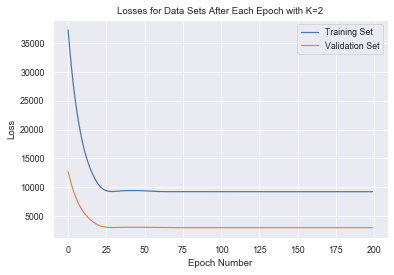

Final training loss: 9203.354089056269
Final validation loss: 2959.569783412575
Cluster 0: 38.06%
Cluster 1: 38.129999999999995%
Cluster 2: 23.810000000000002%


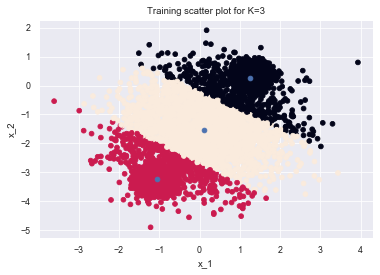

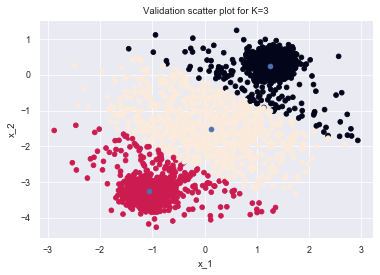

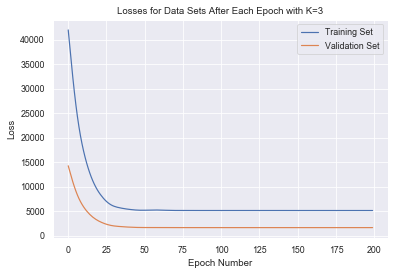

Final training loss: 5110.945371569034
Final validation loss: 1616.4878004580287
Cluster 0: 13.48%
Cluster 1: 12.11%
Cluster 2: 37.28%
Cluster 3: 37.13%


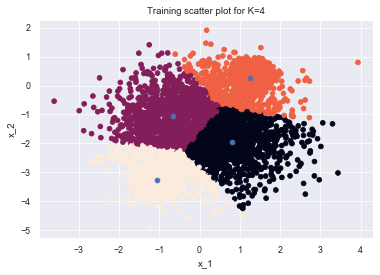

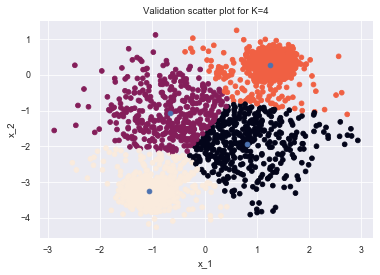

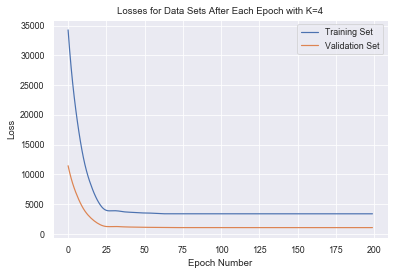

Final training loss: 3374.0360512062193
Final validation loss: 1053.5698238241866
Cluster 0: 7.580000000000001%
Cluster 1: 11.360000000000001%
Cluster 2: 35.92%
Cluster 3: 36.3%
Cluster 4: 8.84%


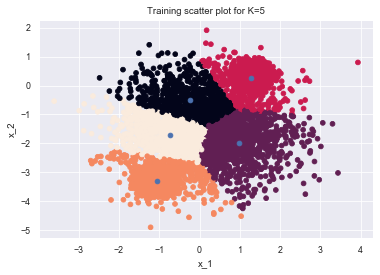

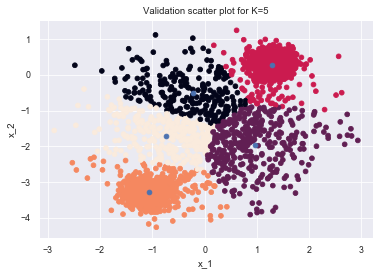

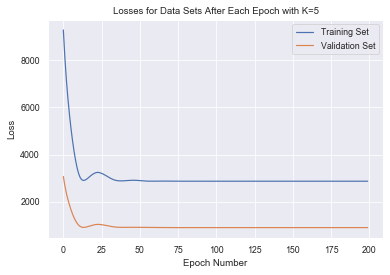

Final training loss: 2873.96835348918
Final validation loss: 908.1155908666058


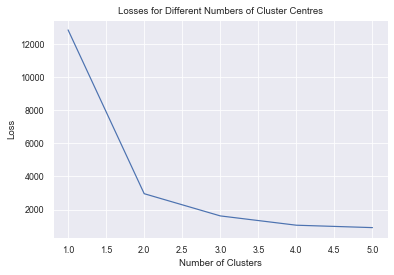

In [8]:
def get_the_right_one(tuple): return tuple[1]

final_losses = []
final_losses.append(get_the_right_one(do_the_learning(data, k=1, use_valid=True)))
final_losses.append(get_the_right_one(do_the_learning(data, k=2, use_valid=True)))
final_losses.append(get_the_right_one(do_the_learning(data, k=3, use_valid=True)))
final_losses.append(get_the_right_one(do_the_learning(data, k=4, use_valid=True)))
final_losses.append(get_the_right_one(do_the_learning(data, k=5, use_valid=True)))


plt.plot([1,2,3,4,5],final_losses)
plt.title('Losses for Different Numbers of Cluster Centres')
plt.ylabel('Loss')
plt.xlabel('Number of Clusters')
plt.show()

The use of the validation data confirms the above statement that 3 cluster centres appear to provide the best
results since it is the best point before returns on the additional computational effort begin to diminish
significantly. (as shown on the above graph which plots validation losses)

## 2. Mixtures of Gaussians
### 2.1 The Gaussian Cluster Mode

Typical Gaussian PDF $= \frac {1}{\sqrt {2\pi \sigma ^{2}}^k}e^{-{\frac {(x-\mu )^{2}}{2\sigma ^{2}}}}$ <br>
Taking the log of the PDF yields:<br>
\begin{align*}
log(PDF) &= log\left(\frac {e^{-{\frac {(x-\mu )^{2}}{2\sigma ^{2}}}}}{\sqrt {2\pi \sigma ^{2}}^k}\right)\\
&= -log\left(e^{\frac {(x-\mu )^{2}}{2\sigma ^{2}}}\right) - klog\left(\sqrt {2\pi \sigma ^{2}}\right)\\
&= -\underbrace{\frac {(x-\mu )^{2}}{2\sigma ^{2}}}_{T1} - \underbrace{klog\left(\sqrt {2\pi \sigma ^{2}}\right)}_{T2}\\
Letting\ DF &= distance\_function(x,\ mu_k) = (x-\mu_k )^{2}\\
&= -\left[\underbrace{\frac {DF}{2\sigma_k^{2}}}_{T1} + \underbrace{klog\left(\sqrt {2\pi \sigma_k^{2}}\right)}_{T2}\right]\\
\end{align*}<br>
T1 and T2 are used to denote terms that will be calculated independently (since it's easier to make tf dimensions align when you can see their shape) in the following section of code.

In [25]:
def log_GaussPDF(X, mu, sigma):
    # Inputs
    # X: N X D
    # mu: K X D
    # sigma: K X 1

    # Outputs:
    # log Gaussian PDF N X K
    sigma_t = tf.transpose(sigma)
    T1 = distanceFunc(X, mu)/(2*sigma_t)
    T2 = tf.cast(tf.rank(X), tf.float64)*tf.log(tf.sqrt(2*np.pi*sigma_t)) # tf doesn't have pi for some reason but numpy does
    return (-1)*(T1 + T2)

Our desired output is $log\left(P(z|\mathbf{x})\right)$. Using Bayes' Rule:<br>
\begin{align*}
P(z|\mathbf{x}) &= \frac{P(\mathbf{x}|z)P(z)}{\Sigma P(\mathbf{x}|z)P(z)}\\
\implies log(P(z|\mathbf{x})) &= log(P(\mathbf{x}|z)P(z)) - log(\Sigma P(\mathbf{x}|z)P(z))\\
Letting\ log\_PDF &= log(P(\mathbf{x}|z)),\ log\_pi = log(P(z)),\ \gamma = log\_PDF + log\_pi = log(P(\mathbf{x}|z)P(z))\\
log(P(z|\mathbf{x})) &= \gamma - log(\Sigma P(\mathbf{x}|z)P(z))\ \ (\mathbf{i})\\
\end{align*}<br>
Note: Gamma was just used as an arbitrary intermediate variable.

In [26]:
def log_posterior(log_PDF, log_pi):
    # Input
    # log_PDF: log Gaussian PDF N X K
    # log_pi: K X 1

    # Outputs
    # log_post: N X K
    lp_transpose = tf.transpose(log_pi)

    gamma = log_PDF + lp_transpose
    summation = hlp.reduce_logsumexp(gamma + lp_transpose, 1, True)
    return gamma - summation

We want to use reduce_logsumexp not reduce_sum because we want to take the log of the sum of the probabilities, not the sum of the log of the probabilities in equation (**i**) and $log(A+B+C) \ne log(A)+log(B)+log(C)$.

### 2.2 Learning the MoG

In [27]:
def mog_loss(log_PDF, log_pi):
    return -tf.reduce_sum(hlp.reduce_logsumexp(log_PDF + tf.transpose(log_pi), 1, keep_dims=True))

In [38]:
def buildGMMGraph(dim, cluster_centers=3):
    tf.set_random_seed(421)
    
    # initialize the placeholder for the data
    x = tf.placeholder(shape=[None, dim], dtype=tf.float64)
    # Sample a random uniform distribution for the cluster centers (stddev chosen emperically for good results)
    mu = tf.Variable(tf.random.normal(shape=[cluster_centers, dim], mean=0.0, stddev=0.05, dtype=tf.float64))
    
    # Randomly initialize and use exp function as hinted in lab docs
    phi = tf.Variable(tf.random.normal(shape=[cluster_centers, 1], mean=0.0, stddev=0.05, dtype=tf.float64))
    sigma = tf.exp(phi)
    
    # Use data, mu/sigma to calculate Gaussian PDF
    log_pdf = log_GaussPDF(x, mu, sigma)
    
    # Initialize pi value randomly too
    psi = tf.Variable(tf.random.normal(shape=[cluster_centers, 1], mean=0.0, stddev=0.05, dtype=tf.float64))
    #raw_pi = tf.nn.softmax(psi, 0)
    log_pi = hlp.logsoftmax(psi) # per lab docs use log softmax
    raw_pi = tf.exp(log_pi)

    # set up the loss function
    loss_function = mog_loss(log_pdf, log_pi)
    
    # set the adam optimizer to minimize the loss function (assume same params as Part 1)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.1, beta1=0.9, beta2=0.99, epsilon=1e-5).minimize(loss_function)
    
    # Make predictions for the cluster to which the data points belong
    # logPosterior provides the probabilities of the N points corresponding to the K clusters
    # Take the best cluster that best predicts by using argmax
    cluster_predictions = tf.argmax(log_posterior(log_pdf, log_pi), 1)
    
    return x, mu, sigma, raw_pi, optimizer, loss_function, cluster_predictions


def do_the_learning_gmm_this_time(train_data, k=3, epochs=200, use_valid=False, plot = True, params=False):
    sess = tf.Session()
    with sess.as_default():
        x, mu, sigma, raw_pi, optimizer, lf, cp = buildGMMGraph(dim=dim, cluster_centers=k)

        init = tf.global_variables_initializer()
        sess.run(init)

        train_loss = np.zeros(epochs)
        val_loss = np.zeros(epochs)
        for i in range(0, epochs):
            sess.run(optimizer, feed_dict={x: train_data})
            train_loss[i] = sess.run(lf, feed_dict={x: train_data})

            if use_valid:
                val_loss[i] = sess.run(lf, feed_dict={x: val_data})
        
        # obtain cluster params
        cluster_means, sigs, pis = sess.run([mu, sigma, raw_pi])
        if params:
            print("Mu:\n", mu.eval(), "\nSigma:\n", np.sqrt(sigs), "\nPi:\n", pis)
        cluster_assignment = sess.run(cp, feed_dict={x: train_data})
        
        if use_valid:
            val_cluster_assignment = sess.run(cp, feed_dict={x: val_data})
    
    count = np.bincount(cluster_assignment)
    for i in range(0, len(count)):
        print("Cluster " + str(i) +":", str(count[i]/len(cluster_assignment)*100) + "%")
    
    if plot:
        # scatter plot
        plt.scatter(train_data[:, 0], train_data[:, 1], c=cluster_assignment)
        plt.scatter(cluster_means[:, 0], cluster_means[:, 1])
        plt.title('Training scatter plot for K=' + str(k))
        plt.show()
        
        if use_valid:
            plt.scatter(val_data[:, 0], val_data[:, 1], c=val_cluster_assignment)
            plt.scatter(cluster_means[:, 0], cluster_means[:, 1])
            plt.title('Validation scatter plot for K=' + str(k))
            plt.show()
            
        # plot losses
        plt.plot(train_loss, label="Training Set")
        if use_valid:
            plt.plot(val_loss, label="Validation Set")
        plt.title('Losses for Data Sets After Each Epoch with K=' + str(k))
        plt.legend()
        plt.ylabel('Loss')
        plt.xlabel('Epoch Number')
        plt.show()
    
    # display final loss
    print("Final training loss:", train_loss[-1])
    if use_valid:
        print("Final validation loss:", val_loss[-1])
        
    return train_loss[-1], val_loss[-1]

#### 2.2.1

Mu:
 [[ 0.1274974  -1.51958267]
 [ 1.29764102  0.31025581]
 [-1.10585757 -3.30741392]] 
Sigma:
 [[0.99899129]
 [0.19648201]
 [0.19506808]] 
Pi:
 [[0.34078775]
 [0.33445826]
 [0.32475399]]
Cluster 0: 32.86335683215839%
Cluster 1: 34.01829908504575%
Cluster 2: 33.11834408279586%


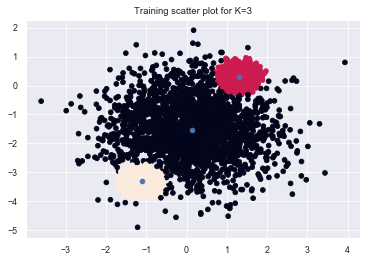

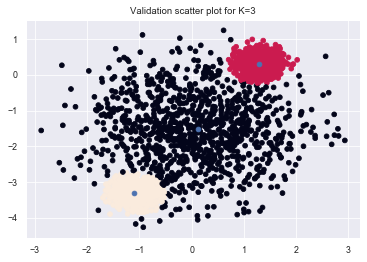

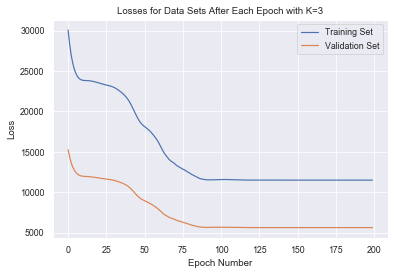

Final training loss: 11506.043000702313
Final validation loss: 5630.130013937949


In [29]:
do_the_learning_gmm_this_time(train_data=data2, k=3, use_valid=True, params=True)

#### 2.2.2

Cluster 0: 100.0%


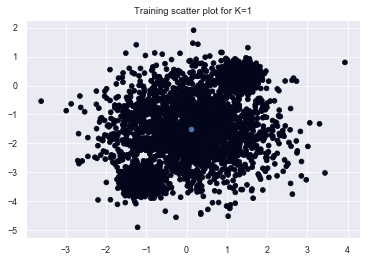

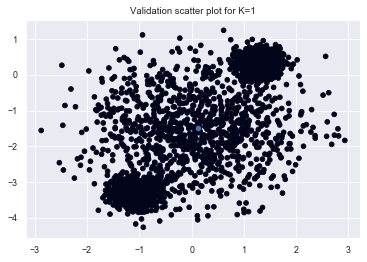

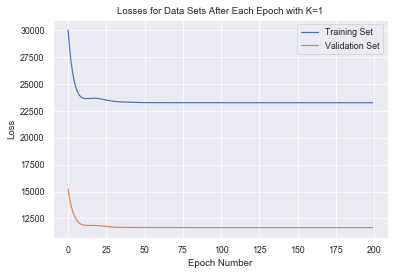

Final training loss: 23265.979469716327
Final validation loss: 11651.446432918943


In [30]:
do_the_learning_gmm_this_time(train_data=data2, k=1, use_valid=True)

Cluster 0: 34.3932803359832%
Cluster 1: 65.6067196640168%


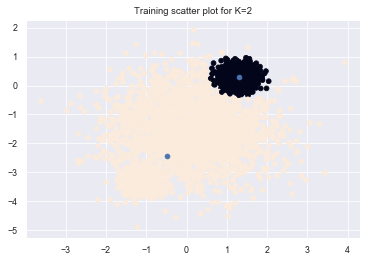

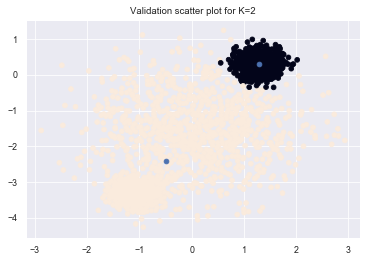

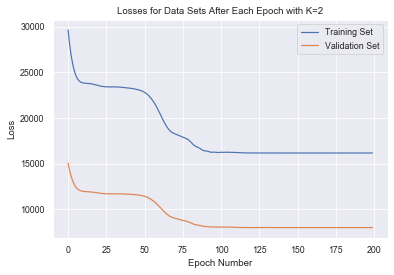

Final training loss: 16155.746942214322
Final validation loss: 7987.676597978645


In [31]:
do_the_learning_gmm_this_time(train_data=data2, k=2, use_valid=True)

Cluster 0: 33.11834408279586%
Cluster 1: 32.86335683215839%
Cluster 2: 34.01829908504575%


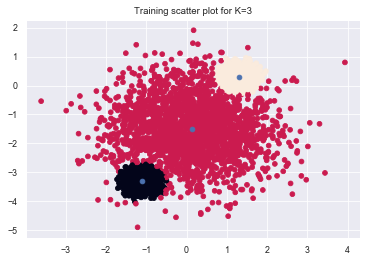

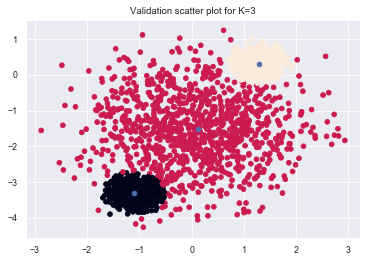

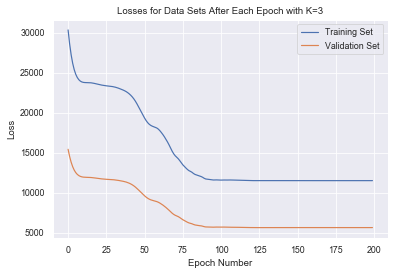

Final training loss: 11505.936407868332
Final validation loss: 5629.816253111207


In [32]:
do_the_learning_gmm_this_time(train_data=data2, k=3, use_valid=True)

Cluster 0: 33.20833958302085%
Cluster 1: 0.0%
Cluster 2: 32.683365831708414%
Cluster 3: 34.10829458527074%


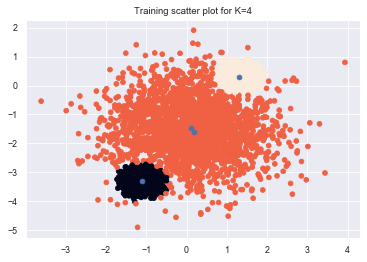

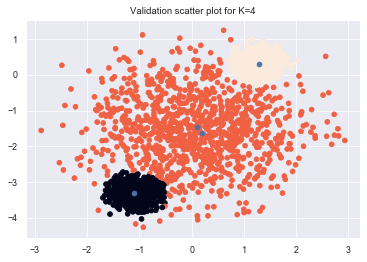

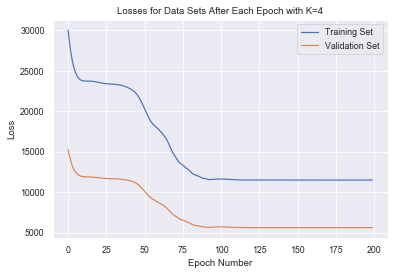

Final training loss: 11505.880726893363
Final validation loss: 5629.591422536161


In [33]:
do_the_learning_gmm_this_time(train_data=data2, k=4, use_valid=True)

Cluster 0: 34.10829458527074%
Cluster 1: 0.02999850007499625%
Cluster 2: 33.23833808309585%
Cluster 3: 1.7099145042747863%
Cluster 4: 30.913454327283635%


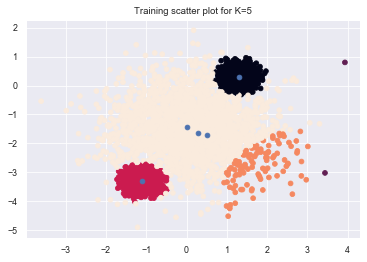

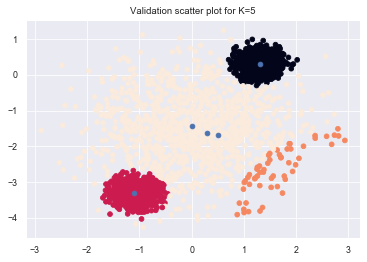

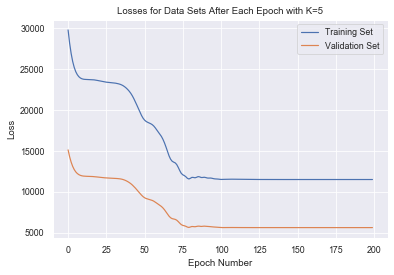

Final training loss: 11505.723046177398
Final validation loss: 5630.718627789685


In [34]:
do_the_learning_gmm_this_time(train_data=data2, k=5, use_valid=True)

Consistent with the K-Means model, K=3 is the best number of clusters for this data. This is evident when looking at the Graphs. For the K=2 graph, one of the centres is responsible for 66% of the points. For the K=3 graph the points are approximately equally shared amongst the centres (approx. 33% each). For K $\gt$ 3, one (for K=4) or two (for K=5) of the cluster centres are barely used. While with more epochs it may be possible for those centres to specialize to outer regions of the data, it is clear that 3 cluster centres represent the best and most efficient proper separation of points.

#### 2.2.3

In [36]:
# Loading data
data_100 = np.load('data100D.npy')
[num_pts, dim] = np.shape(data_100)

USE_VALIDATION = True
# For Validation set
if USE_VALIDATION:
  valid_batch = int(num_pts / 3.0)
  np.random.seed(45689)
  rnd_idx = np.arange(num_pts)
  np.random.shuffle(rnd_idx)
  val_data = data_100[rnd_idx[:valid_batch]]
  data_100 = data_100[rnd_idx[valid_batch:]]

In [ ]:
km_loss = []
gmm_loss = []

km_loss.append(do_the_learning(train_data=data_100, k=5, use_valid=True, plot=True)[1])
gmm_loss.append(do_the_learning_gmm_this_time(train_data=data_100, k=5, use_valid=True, plot=False)[1])
km_loss.append(do_the_learning(train_data=data_100, k=10, use_valid=True, plot=False)[1])
gmm_loss.append(do_the_learning_gmm_this_time(train_data=data_100, k=10, use_valid=True, plot=False)[1])
km_loss.append(do_the_learning(train_data=data_100, k=15, use_valid=True, plot=False)[1])
gmm_loss.append(do_the_learning_gmm_this_time(train_data=data_100, k=15, use_valid=True, plot=False)[1])
km_loss.append(do_the_learning(train_data=data_100, k=20, use_valid=True, plot=False)[1])
gmm_loss.append(do_the_learning_gmm_this_time(train_data=data_100, k=20, use_valid=True, plot=False)[1])
km_loss.append(do_the_learning(train_data=data_100, k=30, use_valid=True, plot=False)[1])
gmm_loss.append(do_the_learning_gmm_this_time(train_data=data_100, k=30, use_valid=True, plot=False)[1])


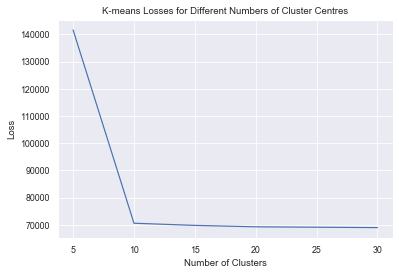

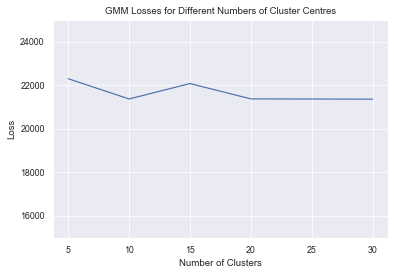

K-Means Validation Losses: [141652.86251030513, 70620.6561951589, 69827.3802224346, 69300.68149350214, 69007.40537816245]
GMM Validation Losses: [22303.140988451778, 21370.810128108722, 22079.7654876328, 21375.10866513839, 21362.417439398734]


In [44]:
x_val = [5, 10, 15, 20, 30]
plt.plot(x_val, km_loss)
plt.title('K-means Losses for Different Numbers of Cluster Centres')
plt.ylabel('Loss')
plt.xlabel('Number of Clusters')
plt.show()

plt.plot(x_val, gmm_loss)
plt.title('GMM Losses for Different Numbers of Cluster Centres')
plt.ylabel('Loss')
plt.xlabel('Number of Clusters')
plt.ylim([15000, 25000])
plt.show()

print("K-Means Validation Losses:", km_loss)
print("GMM Validation Losses:", gmm_loss)

There appear to be 10 clusters in the data. The largest gains in the K-means data is from 5 to 10, and the improvments afterwards are negligible. The GMM data also suggests this as the data shows improvement from K=5 to K=10 but gets worse and also shows similar losses for K=20, K=30. These results, with the losses approximately the same for K$\gt$10 implies that the extra cluster centres are barely used. The GMM validation losses are significantly lower (approximately an order of magnitude) than the K-Means validation losses.